In [1]:
from samplers import *

import numpy as np
import sklearn
import sklearn.metrics
import scipy
import torch
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt


In [16]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
    
    def forward(self, x):
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    def name(self):
        return "MLP"


In [46]:
D = MLP()

In [47]:
lr = 0.001
optimizer = torch.optim.SGD(D.parameters(), lr=lr)

In [48]:
losses = []
n_epochs = 100000
for epoch in range(n_epochs):
    x_d = torch.FloatTensor(next(distribution4(512)))
    y_g = torch.FloatTensor(next(distribution2()))
    optimizer.zero_grad()
    loss = -(np.log(2) + 0.5 * torch.mean(torch.log(D(x_d))) + 0.5 * torch.mean(torch.log(1 - D(y_g))))
    loss.backward()
    optimizer.step()
    losses.append(loss.data.numpy())
    if epoch % 1000 == 0:
        print(loss.data)
    

/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0012)
tensor(-0.0002)
tensor(-0.0030)
tensor(-0.0035)
tensor(-0.0036)
tensor(-0.0055)
tensor(-0.0099)
tensor(-0.0078)
tensor(-0.0098)
tensor(-0.0093)
tensor(-0.0136)
tensor(-0.0168)
tensor(-0.0160)
tensor(-0.0211)
tensor(-0.0222)
tensor(-0.0248)
tensor(-0.0263)
tensor(-0.0299)
tensor(-0.0330)
tensor(-0.0385)
tensor(-0.0558)
tensor(-0.0417)
tensor(-0.0497)
tensor(-0.0600)
tensor(-0.0725)
tensor(-0.0764)
tensor(-0.0698)
tensor(-0.0810)
tensor(-0.1006)
tensor(-0.1024)
tensor(-0.1042)
tensor(-0.1277)
tensor(-0.1294)
tensor(-0.1377)
tensor(-0.1346)
tensor(-0.1822)
tensor(-0.1939)
tensor(-0.2051)
tensor(-0.1986)
tensor(-0.2204)
tensor(-0.2227)
tensor(-0.2708)
tensor(-0.2598)
tensor(-0.3121)
tensor(-0.2799)
tensor(-0.3124)
tensor(-0.2881)
tensor(-0.3525)
tensor(-0.3427)
tensor(-0.4249)
tensor(-0.4696)
tensor(-0.4393)
tensor(-0.4993)
tensor(-0.5246)
tensor(-0.5315)
tensor(-0.4788)
tensor(-0.5082)
tensor(-0.5100)
tensor(-0.5744)
tensor(-0.5619)
tensor(-0.5705)
tensor(-0.5894)
tensor(-0

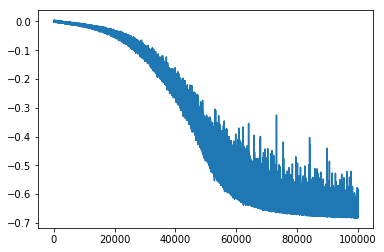

In [49]:
plt.plot(np.array(losses).flatten())

In [248]:
def jsd(p, q):
    # find the norm and calculate r
    p = (p / p.sum()).flatten()
    q = (q / q.sum()).flatten()
    r = 0.5 * (p + q)
    
    # find the first kl and do some data wrangling (we get some nans)
    first_kl = p * np.log(p / r)
    first_kl[np.isnan(first_kl)] = 100.
    first_kl = np.sum(first_kl)

    # find the first kl and do some data wrangling (we get some nans)
    second_kl = q * np.log(q / r)
    second_kl[np.isnan(second_kl)] = 100.
    second_kl = np.sum(second_kl)
    
    # find the JSD
    return np.log(2) + first_kl / 2. + second_kl / 2.


In [261]:
jsd(x_d.flatten().numpy(), y_g[:512, 0].numpy())

/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


9000.440461633685

In [50]:

jsd(next(distribution3()), next(distribution3()))

/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


0.20500252021681908

In [88]:
def calc_gradient_penalty(D, real_data, fake_data):
    alpha = torch.rand(512, 1)
    alpha = alpha.expand(real_data.size())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = D(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs= torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    lamb = 10
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamb
    return gradient_penalty


In [103]:
D = MLP()

In [104]:
lr = 0.001
optimizer = torch.optim.SGD(D.parameters(), lr=lr)

In [105]:
d_losses = []
gp_losses = []
total_losses = []
n_epochs = 100000

one = torch.FloatTensor([1])
mone = one * -1

for epoch in range(n_epochs):
    x_d = torch.FloatTensor(next(distribution4(512)))
    y_g = torch.FloatTensor(next(distribution2()))
    optimizer.zero_grad()
    
    d_real = D(x_d)
    d_real_loss = torch.mean(d_real)
    d_real_loss.backward(mone)
   
    d_fake = D(y_g)
    d_fake_loss = torch.mean(d_fake)
    d_fake_loss.backward(one)
    
    d_losses.append(d_fake_loss + d_real_loss)
    
    gradient_penalty = calc_gradient_penalty(D, x_d.data, y_g.data)
    gp_losses.append(gradient_penalty.data.numpy())
    gradient_penalty.backward()
    optimizer.step()

    cost = d_loss + gradient_penalty
    total_losses.append(cost.data.numpy())
    if epoch % 1000 == 0:
        print(cost.data)
    

/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(9.3642)
tensor(0.1925)
tensor(0.1144)
tensor(0.1361)
tensor(0.0945)
tensor(0.0500)
tensor(0.0203)
tensor(-0.0280)
tensor(-0.0355)
tensor(-0.0462)
tensor(-0.0161)


KeyboardInterrupt: 

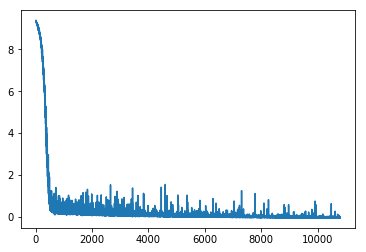

In [106]:
plt.plot(np.array(total_losses).flatten())

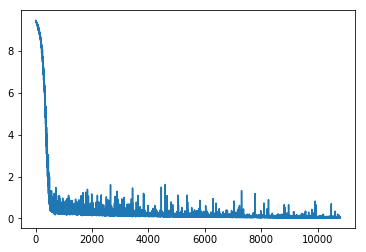

In [107]:
plt.plot(np.array(gp_losses).flatten())

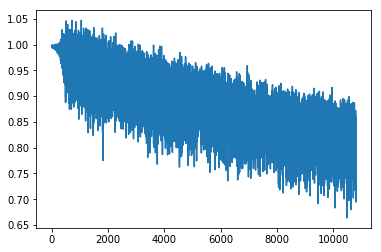

In [108]:
plt.plot(np.array(d_losses).flatten())